In [2]:
# Google colab link: https://colab.research.google.com/drive/1naZ2DyxELRxfW9-jm1xsbz3pucnLdIaK

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
import pandas as pd
import numpy as np

# Read data
train = pd.read_csv('train-balanced-sarcasm.csv')
train = train.dropna(subset = ['comment']) # drop na values

In [0]:
# without meta-data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# for meta-data, same as Logistic Regression and SVM
# change to CountVectorizer for experimentation
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english', max_features = 500) 
one_hot = tfidf_vectorizer.fit_transform(train['comment']).toarray()

In [5]:
print(one_hot.shape)

(1010773, 500)


In [6]:
y = np.asarray(train['label'])
print(y.shape)

(1010773,)


In [0]:
np.random.seed(1001)
mask = np.random.rand((len(y))) # for train-test split

In [8]:
x_train = torch.from_numpy(one_hot[mask <= 0.85])
x_test = torch.from_numpy(one_hot[mask > 0.85])
print(x_train.shape, x_test.shape)

torch.Size([859133, 500]) torch.Size([151640, 500])


In [9]:
y_train = torch.from_numpy(y[mask <= 0.85])
y_test = torch.from_numpy(y[mask > 0.85])
print(y_train.shape, y_test.shape)

torch.Size([859133]) torch.Size([151640])


In [0]:
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)
# Data loader
train_loader = DataLoader(train, batch_size = 500, shuffle = True)
test_loader = DataLoader(test, batch_size = 500, shuffle = False)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from torch.optim.lr_scheduler import MultiStepLR

# Neural network architecture
# 3 hidden layers, RELU + dropout
net = torch.nn.Sequential(
    torch.nn.Linear(500, 256), torch.nn.PReLU(), torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128), torch.nn.PReLU(), torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64), torch.nn.PReLU(), torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 2), torch.nn.Sigmoid())

loss_fn = torch.nn.CrossEntropyLoss() # Loss function
lr = 1e-3 # Learning rate
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=1e-3/3) # Adam 
scheduler = MultiStepLR(optimizer, milestones=[50, 80], gamma = 0.1)
epochs = 200

In [16]:
train_len = x_train.shape[0]
losses = [] # to plot losses
for epoch in range(epochs):
    scheduler.step()
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        net.to(device)
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.to(device) # move to GPU
        labels = labels.to(device)
        #clear grads
        optimizer.zero_grad()
        #forward to get predicted values
        outputs = net.forward(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        # back props 
        optimizer.step()
        # update the parameters
        running_loss += loss.item()
        
    loss_ = running_loss / (train_len / 5000)
    print('Epoch: {}, Loss: {}'.format(epoch + 1, loss_))
    losses.append(loss_)

Epoch: 1, Loss: 6.480143215908501
Epoch: 2, Loss: 6.445178324962114
Epoch: 3, Loss: 6.434603117771789
Epoch: 4, Loss: 6.426949951606705
Epoch: 5, Loss: 6.422431302862383
Epoch: 6, Loss: 6.419205835827302
Epoch: 7, Loss: 6.416995644720224
Epoch: 8, Loss: 6.415138520385714
Epoch: 9, Loss: 6.413544275670034
Epoch: 10, Loss: 6.411292956093306
Epoch: 11, Loss: 6.410623857735356
Epoch: 12, Loss: 6.408905699993555
Epoch: 13, Loss: 6.4082733277452775
Epoch: 14, Loss: 6.408109036915883
Epoch: 15, Loss: 6.407991687364124
Epoch: 16, Loss: 6.407967179008825
Epoch: 17, Loss: 6.406821826889488
Epoch: 18, Loss: 6.406744932497103
Epoch: 19, Loss: 6.407217373261808
Epoch: 20, Loss: 6.405786441844169
Epoch: 21, Loss: 6.405873309276453
Epoch: 22, Loss: 6.405097994401264
Epoch: 23, Loss: 6.4040422501321315
Epoch: 24, Loss: 6.403283145002383
Epoch: 25, Loss: 6.40342229822102
Epoch: 26, Loss: 6.404372771243653
Epoch: 27, Loss: 6.403445900850853
Epoch: 28, Loss: 6.403101105977742
Epoch: 29, Loss: 6.403169555

200
200



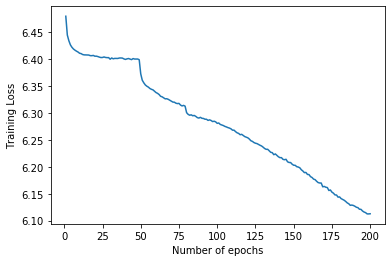

In [17]:
import matplotlib.pyplot as plt
print(len(losses)) # sanity check
epochs_ = []
for i in range(1, 201): # 200 epochs
    epochs_.append(i)
print(len(epochs_)) # sanity check
print()
plt.plot(epochs_, losses)
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.show()

In [18]:
# Performance on train set
with torch.no_grad():
    correct, total = 0, 0
    tp, fp, fn, tn = 0, 0, 0, 0 # for confusion matrix
    for i, data in enumerate(train_loader, 0): 
        inputs, labels = data 
        net.to(device) 
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.to(device) # move to GPU
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # true positives
        tp += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        # false negatives
        fn += (predicted[labels == 1] != labels[labels == 1]).sum().item()
        # false positives
        fp += (predicted[labels == 0] != labels[labels == 0]).sum().item()
        # true negatives
        tn += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        precision = (tp / (tp + fp))
        recall =  (tp / (tp + fn))
        f1 = 2 * (precision * recall) / (precision + recall)

print("Feed-forward Neural Network for TF-IDF vectorization:")
print("Training accuracy: ", (100 * correct) / total)
print("Precision: ", precision, " | Recall: ", recall, " | F1-score: ", f1)
print("Confusion matrix values: ")
print("TP: ", tp, ", FN: ", fn, ", FP: ", fp, ", TN: ", tn)

Feed-forward Neural Network for TF-IDF vectorization:
Training accuracy:  67.66495990725534
Precision:  0.723756954948739  | Recall:  0.5714032972200366  | F1-score:  0.6386192129524235
Confusion matrix values: 
TP:  245460 , FN:  184114 , FP:  93687 , TN:  335872


In [20]:
# Performance on test set
with torch.no_grad():
    correct, total = 0, 0
    tp, fp, fn, tn = 0, 0, 0, 0 # for confusion matrix
    for i, data in enumerate(test_loader, 0): 
        inputs, labels = data 
        net.to(device) 
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.to(device) # move to GPU
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # true positives
        tp += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        # false negatives
        fn += (predicted[labels == 1] != labels[labels == 1]).sum().item()
        # false positives
        fp += (predicted[labels == 0] != labels[labels == 0]).sum().item()
        # true negatives
        tn += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        precision = (tp / (tp + fp))
        recall =  (tp / (tp + fn))
        f1 = 2 * (precision * recall) / (precision + recall)

print("Testing accuracy: ", (100 * correct) / total)
print("Precision: ", precision, " | Recall: ", recall, " | F1-score: ", f1)
print("Confusion matrix values: ")
print("TP: ", tp, ", FN: ", fn, ", FP: ", fp, ", TN: ", tn)

Testing accuracy:  65.54009496175152
Precision:  0.6851977152208463  | Recall:  0.574517771855292  | F1-score:  0.6249955147296279
Confusion matrix values: 
TP:  43545 , FN:  32249 , FP:  20006 , TN:  55840
